# Capstone project: The Battle of Neighborhoods Week 1

### Import library

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

### Scrape the website pages and create dataframe

#### Toronto

In [2]:
# Read data
d = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df = d[0]
# Rename Postal code column
df.rename(columns={"Postal code": "PostalCode"}, inplace = True)
# Ignore cells with a borough that is Not assigned
df = df[df.Borough != 'Not assigned']
# Replace ' /' by ','
df = df.assign(Neighborhood=df['Neighborhood'].str.replace(' /', ','))
# Reset index
df.reset_index(drop=True, inplace=True)

In [3]:
## Add Latitude/Longitude
df2 = pd.read_csv('C:/Users/michm/Documents/Jupiter notebook/coursera/Geospatial_Coordinates.csv')
# Rename Postal code column
df2.rename(columns={"Postal Code": "PostalCode"}, inplace = True)


In [4]:
# Merge dataframes
data_toronto = pd.merge(df,df2,on='PostalCode')
# Select only Borough that contain the word 'Toronto'
data_toronto = data_toronto[data_toronto['Borough'].str.contains("Toronto")]
# Reset index
data_toronto.reset_index(drop=True, inplace=True)
data_toronto = data_toronto.drop('PostalCode', 1)
# Add City column
data_toronto['City'] = 'Toronto'
data_toronto.head()

Borough                                 Neighborhood   Latitude  \
0  Downtown Toronto                    Regent Park, Harbourfront  43.654260   
1  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.662301   
2  Downtown Toronto                     Garden District, Ryerson  43.657162   
3  Downtown Toronto                               St. James Town  43.651494   
4      East Toronto                                  The Beaches  43.676357   

   Longitude     City  
0 -79.360636  Toronto  
1 -79.389494  Toronto  
2 -79.378937  Toronto  
3 -79.375418  Toronto  
4 -79.293031  Toronto

In [5]:
data_toronto.shape

(39, 5)

#### New York

In [6]:
!wget -q -O newyork_data.json https://cocl.us/new_york_dataset 

In [7]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [8]:
neighborhoods_data = newyork_data['features']

In [9]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
data_newyork = pd.DataFrame(columns=column_names)

In [10]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    data_newyork = data_newyork.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [11]:
data_newyork['City'] = 'New York'
data_newyork.head()

Borough Neighborhood   Latitude  Longitude      City
0   Bronx    Wakefield  40.894705 -73.847201  New York
1   Bronx   Co-op City  40.874294 -73.829939  New York
2   Bronx  Eastchester  40.887556 -73.827806  New York
3   Bronx    Fieldston  40.895437 -73.905643  New York
4   Bronx    Riverdale  40.890834 -73.912585  New York

In [12]:
data_newyork.shape

(306, 5)

#### Paris

In [13]:
# Load Boroughs in Paris
with open('arrondissements.json') as json_data:
    arrondissements_data = json.load(json_data)

In [14]:
# Load Neighborhoods in Paris
with open('quartier_paris.json') as json_data2:
    quartier_data = json.load(json_data2)

In [15]:
# define the dataframe columns
column_names = ['Borough number', 'Borough name'] 

# instantiate the dataframe
borough_paris = pd.DataFrame(columns=column_names)

In [16]:
for data in arrondissements_data:
    borough_name = data['fields']['l_aroff'] 
    borough_number = data['fields']['c_ar']
               
    borough_paris = borough_paris.append({'Borough number': borough_number,
                                          'Borough name': borough_name}, ignore_index=True)

In [17]:
# define the dataframe columns
column_names = ['Borough number', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_paris = pd.DataFrame(columns=column_names)

In [18]:
for data in quartier_data:
    neighborhood_name2 = data['fields']['l_qu'] 
    borough_number2 = data['fields']['c_ar']
           
    neighborhood_latlon2 = data['fields']['geom_x_y']
    neighborhood_lat2 = neighborhood_latlon2[0]
    neighborhood_lon2 = neighborhood_latlon2[1]
    
    neighborhoods_paris = neighborhoods_paris.append({'Borough number': borough_number2,
                                          'Neighborhood': neighborhood_name2,
                                          'Latitude': neighborhood_lat2,
                                          'Longitude': neighborhood_lon2}, ignore_index=True)

In [19]:
# Merge dataframes
data_paris = pd.merge(neighborhoods_paris,borough_paris,on='Borough number')
# Select columns
data_paris = data_paris[['Borough name', 'Neighborhood', 'Latitude', 'Longitude']]
# Rename column Borough
data_paris.rename(columns={"Borough name": "Borough"}, inplace = True)
data_paris['City'] = 'Paris'
data_paris.head()

Borough         Neighborhood   Latitude  Longitude   City
0    Opéra         Rochechouart  48.879812   2.344861  Paris
1    Opéra        Saint-Georges  48.879934   2.332850  Paris
2    Opéra     Chaussée-d'Antin  48.873547   2.332269  Paris
3    Opéra  Faubourg-Montmartre  48.873935   2.343253  Paris
4  Reuilly                Bercy  48.835209   2.386210  Paris

In [20]:
data_paris.shape

(80, 5)

#### 2.2 Merge dataframes of the 3 cities

In [21]:
data_cities = data_toronto.append([data_newyork, data_paris])

In [22]:
data_cities.shape

(425, 5)

#### 2.3 Use geopy library to get the latitude and longitude values of Toronto.

In [23]:
address_toronto = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address_toronto)
latitude_toronto = location.latitude
longitude_toronto = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [24]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_newyork = location.latitude
longitude_newyork = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude_newyork, longitude_newyork))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [25]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude_paris = location.latitude
longitude_paris = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude_paris, longitude_paris))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [26]:
address = 'Rome, Italy'

geolocator = Nominatim(user_agent="italy_explorer")
location = geolocator.geocode(address)
latitude_rome = location.latitude
longitude_rome = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude_rome, longitude_rome))

The geograpical coordinate of Paris are 41.8933203, 12.4829321.


#### 2.4 Create a maps with neighborhoods superimposed on top.

#### Toronto

In [27]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(data_toronto['Latitude'], data_toronto['Longitude'], data_toronto['Borough'], data_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Paris

In [28]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude_paris, longitude_paris], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(data_paris['Latitude'], data_paris['Longitude'], data_paris['Borough'], data_paris['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

#### New York

In [29]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude_newyork, longitude_newyork], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(data_newyork['Latitude'], data_newyork['Longitude'], data_newyork['Borough'], data_newyork['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Define Foursquare Credentials and Version

In [30]:
CLIENT_ID = 'LLKS5KEFXOZYPPENEKR3OUSBHRKWBUMM22P0NUVVXPS31YBZ' # your Foursquare ID
CLIENT_SECRET = 'JW0XKD5H43THSOX1JU2MGWPLBKZYYIKFLJLAGIFU2OZHNVYO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LLKS5KEFXOZYPPENEKR3OUSBHRKWBUMM22P0NUVVXPS31YBZ
CLIENT_SECRET:JW0XKD5H43THSOX1JU2MGWPLBKZYYIKFLJLAGIFU2OZHNVYO


## 2. Explore Neighborhoods in Toronto, New York and Paris


In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [32]:
cities_venues = getNearbyVenues(names=data_cities['Neighborhood'],
                                   latitudes=data_cities['Latitude'],
                                   longitudes=data_cities['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town,

#### Let's check the size of the resulting dataframe

In [33]:
print(cities_venues.shape)
cities_venues.head()

(16424, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Regent Park, Harbourfront               43.65426              -79.360636   
1  Regent Park, Harbourfront               43.65426              -79.360636   
2  Regent Park, Harbourfront               43.65426              -79.360636   
3  Regent Park, Harbourfront               43.65426              -79.360636   
4  Regent Park, Harbourfront               43.65426              -79.360636   

                    Venue  Venue Latitude  Venue Longitude  \
0        Roselle Desserts       43.653447       -79.362017   
1           Tandem Coffee       43.653559       -79.361809   
2      Morning Glory Cafe       43.653947       -79.361149   
3  Cooper Koo Family YMCA       43.653249       -79.358008   
4     Body Blitz Spa East       43.654735       -79.359874   

        Venue Category  
0               Bakery  
1          Coffee Shop  
2       Breakfast Spot  
3  Distribution Center  
4                  Spa

#### Let's find out how many unique categories can be curated from all the returned venues

In [34]:
cities_venues[cities_venues['Venue Category']=='Neighborhood'] = 'Neighborhood Restaurant'
print('There are {} uniques categories.'.format(len(cities_venues['Venue Category'].unique())))

There are 495 uniques categories.


## 3. Analyze Each Neighborhood

In [35]:
# one hot encoding
cities_onehot = pd.get_dummies(cities_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['Neighborhood'] = cities_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]

cities_onehot.head()


Neighborhood  Accessories Store  Adult Boutique  \
0  Regent Park, Harbourfront                  0               0   
1  Regent Park, Harbourfront                  0               0   
2  Regent Park, Harbourfront                  0               0   
3  Regent Park, Harbourfront                  0               0   
4  Regent Park, Harbourfront                  0               0   

   Afghan Restaurant  African Restaurant  Airport  Airport Food Court  \
0                  0                   0        0                   0   
1                  0                   0        0                   0   
2                  0                   0        0                   0   
3                  0                   0        0                   0   
4                  0                   0        0                   0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0             0               0                0                 0   
1             0               0                0                 0   
2             0               0                0                 0   
3             0               0                0                 0   
4             0               0                0                 0   

   Alsatian Restaurant  American Restaurant  Animal Shelter  Antique Shop  \
0                    0                    0               0             0   
1                    0                    0               0             0   
2                    0                    0               0             0   
3                    0                    0               0             0   
4                    0                    0               0             0   

   Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0         0       0                 0                       0            0   
1         0       0                 0                       0            0   
2         0       0                 0                       0            0   
3         0       0                 0                       0            0   
4         0       0                 0                       0            0   

   Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    0                     0                 0   
3           0                    0                     0                 0   
4           0                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   
3                   0           0                      0                    0   
4                   0           0                      0                    0   

   Auto Garage  Auto Workshop  Automotive Shop  Auvergne Restaurant  \
0            0              0                0                    0   
1            0              0                0                    0   
2            0              0                0                    0   
3            0              0                0                    0   
4            0              0                0                    0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       1     0    0               0   
1          0           0           0       0     0    0               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0        

And let's examine the new dataframe size.

In [36]:
cities_onehot.shape

(16424, 496)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [37]:
cities_grouped = cities_onehot.groupby('Neighborhood').mean().reset_index()
cities_grouped.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0       Allerton                0.0             0.0                0.0   
1       Amérique                0.0             0.0                0.0   
2       Annadale                0.0             0.0                0.0   
3       Archives                0.0             0.0                0.0   
4  Arden Heights                0.0             0.0                0.0   

   African Restaurant  Airport  Airport Food Court  Airport Gate  \
0                 0.0      0.0                 0.0           0.0   
1                 0.0      0.0                 0.0           0.0   
2                 0.0      0.0                 0.0           0.0   
3                 0.0      0.0                 0.0           0.0   
4                 0.0      0.0                 0.0           0.0   

   Airport Lounge  Airport Service  Airport Terminal  Alsatian Restaurant  \
0             0.0              0.0               0.0                  0.0   
1             0.0              0.0               0.0                  0.0   
2             0.0              0.0               0.0                  0.0   
3             0.0              0.0               0.0                  0.0   
4             0.0              0.0               0.0                  0.0   

   American Restaurant  Animal Shelter  Antique Shop  Aquarium  Arcade  \
0             0.031250             0.0           0.0       0.0     0.0   
1             0.000000             0.0           0.0       0.0     0.0   
2             0.071429             0.0           0.0       0.0     0.0   
3             0.000000             0.0           0.0       0.0     0.0   
4             0.000000             0.0           0.0       0.0     0.0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0               0.0                     0.0         0.00        0.00   
1               0.0                     0.0         0.00        0.00   
2               0.0                     0.0         0.00        0.00   
3               0.0                     0.0         0.04        0.01   
4               0.0                     0.0         0.00        0.00   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                  0.0                   0.0              0.00   
1                  0.0                   0.0              0.00   
2                  0.0                   0.0              0.00   
3                  0.0                   0.0              0.01   
4                  0.0                   0.0              0.00   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                 0.0         0.0                    0.0                  0.0   
1                 0.0         0.0                    0.0                  0.0   
2                 0.0         0.0                    0.0                  0.0   
3                 0.0         0.0                    0.0                  0.0   
4                 0.0         0.0                    0.0                  0.0   

   Auto Garage  Auto Workshop  Automotive Shop  Auvergne Restaurant  \
0          0.0            0.0              0.0                  0.0   
1          0.0            0.0              0.0                  0.0   
2          0.0            0.0              0.0                  0.0   
3          0.0            0.0              0.0                  0.0   
4          0.0            0.0              0.0                  0.0   

   BBQ Joint  Baby Store  Bagel Shop    Bakery  Bank   Bar  Baseball Field  \
0        0.0         0.0    0.000000  0.062500   0.0  0.00             0.0   
1        0.0         0.0    0.000000  0.062500   0.0  0.00             0.0   
2        0.0         0.0    0.071429  0.142857   0.0  0.00             0.0   
3        0.0         0.0    0.000000  0.000000   0.0  0.04             0.0   
4        0.0         0.0    0.000000  0.000000   0.0  0.00             0.0   

   Baseball Stadium  Basketba

#### Let's confirm the new size


In [38]:
cities_grouped.shape

(419, 496)

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cities_grouped['Neighborhood']

for ind in np.arange(cities_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Pizza Place      Department Store   
1       Amérique                Bistro     French Restaurant   
2       Annadale           Pizza Place                Bakery   
3       Archives     French Restaurant                 Hotel   
4  Arden Heights              Bus Stop              Pharmacy   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Bakery    Chinese Restaurant           Supermarket   
1           Supermarket              Bus Stop     Martial Arts Dojo   
2            Restaurant         Train Station          Dance Studio   
3           Coffee Shop                Bistro    Italian Restaurant   
4           Pizza Place           Coffee Shop   Dumpling Restaurant   

  6th Most Common Venue 7th Most Common Venue        8th Most Common Venue  \
0         Deli / Bodega     Electronics Store            Martial Arts Dojo   
1               Theater                  Park            Health Food Store   
2   American Restaurant      Sushi Restaurant                         Park   
3                   Bar           Art Gallery          Japanese Restaurant   
4        Duty-free Shop   EV Charging Station  Eastern European Restaurant   

   9th Most Common Venue 10th Most Common Venue  
0  Check Cashing Service             Donut Shop  
1        Bed & Breakfast                   Café  
2             Sports Bar             Bagel Shop  
3         Clothing Store           Cocktail Bar  
4    Egyptian Restaurant      Electronics Store

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 10 clusters.

In [41]:
# set number of clusters
kclusters = 8

cities_grouped_clustering = cities_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [42]:
# add clustering labels
#del neighborhoods_venues_sorted
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cities_merged = data_cities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
cities_merged = cities_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
cities_merged.dropna(inplace=True)
cities_merged = cities_merged.astype({"Cluster Labels": int} )



cities_merged # check the last columns!

Borough                                       Neighborhood  \
0       Downtown Toronto                          Regent Park, Harbourfront   
1       Downtown Toronto        Queen's Park, Ontario Provincial Government   
2       Downtown Toronto                           Garden District, Ryerson   
3       Downtown Toronto                                     St. James Town   
4           East Toronto                                        The Beaches   
5       Downtown Toronto                                        Berczy Park   
6       Downtown Toronto                                 Central Bay Street   
7       Downtown Toronto                                           Christie   
8       Downtown Toronto                           Richmond, Adelaide, King   
9           West Toronto                       Dufferin, Dovercourt Village   
10      Downtown Toronto  Harbourfront East, Union Station, Toronto Islands   
11          West Toronto                           Little Portugal, Trinity   
12          East Toronto                       The Danforth West, Riverdale   
13      Downtown Toronto           Toronto Dominion Centre, Design Exchange   
14          West Toronto       Brockton, Parkdale Village, Exhibition Place   
15          East Toronto                     India Bazaar, The Beaches West   
16      Downtown Toronto                     Commerce Court, Victoria Hotel   
17          East Toronto                                    Studio District   
18       Central Toronto                                      Lawrence Park   
19       Central Toronto                                           Roselawn   
20       Central Toronto                                   Davisville North   
21       Central Toronto                           Forest Hill North & West   
22          West Toronto                      High Park, The Junction South   
23       Central Toronto                                 North Toronto West   
24       Central Toronto                The Annex, North Midtown, Yorkville   
25          West Toronto                             Parkdale, Roncesvalles   
26       Central Toronto                                         Davisville   
27      Downtown Toronto                     University of Toronto, Harbord   
28          West Toronto                                 Runnymede, Swansea   
29       Central Toronto                        Moore Park, Summerhill East   
30      Downtown Toronto          Kensington Market, Chinatown, Grange Park   
31       Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
32      Downtown Toronto  CN Tower, King and Spadina, Railway Lands, Har...   
33      Downtown Toronto                                           Rosedale   
34      Downtown Toronto                                     Stn A PO Boxes   
35      Downtown Toronto                        St. James Town, Cabbagetown   
36      Downtown Toronto             First Canadian Place, Underground city   
37      Downtown Toronto                               Church and Wellesley   
38          East Toronto              Business reply mail Processing Centre   
0                  Bronx                                          Wakefield   
1                  Bronx                                         Co-op City   
2                  Bronx                                        Eastchester   
3                  Bronx                                          Fieldston   
4                  Bronx                                          Riverdale   
5                  Bronx                                        Kingsbridge   
6              Manhattan                                        Marble Hill   
7                  Bronx                                           Woodlawn   
8                  Bronx                                            Norwood   
9                  Bronx                                     Williamsbridge   
10                 Bronx                                         Ba

Finally, let's visualize the resulting clusters

In [43]:
# create map
map_clusters = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['Neighborhood'], cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [44]:
# create map
map_clusters = folium.Map(location=[latitude_newyork, longitude_newyork], zoom_start=10.4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['Neighborhood'], cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [45]:
# create map
map_clusters = folium.Map(location=[latitude_paris, longitude_paris], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['Neighborhood'], cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters


### Cluster 1

In [46]:
cluster1 = cities_merged.loc[cities_merged['Cluster Labels'] == 0, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]
cluster1

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
76    Mill Island               0                  Pool           Zoo Exhibit   
238  Butler Manor               0        Baseball Field                  Pool   

    3rd Most Common Venue 4th Most Common Venue        5th Most Common Venue  \
76         Duty-free Shop   EV Charging Station  Eastern European Restaurant   
238     Convenience Store              Bus Stop          EV Charging Station   

           6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
76           Egyptian Restaurant     Electronics Store   Empanada Restaurant   
238  Eastern European Restaurant   Egyptian Restaurant     Electronics Store   

    9th Most Common Venue 10th Most Common Venue  
76     English Restaurant  Entertainment Service  
238   Empanada Restaurant     English Restaurant

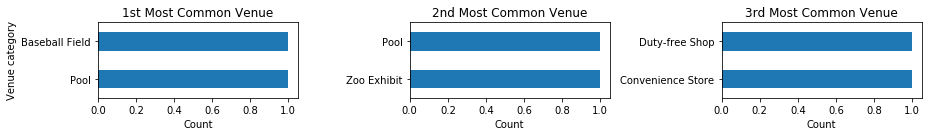

In [47]:
plt.figure(figsize=(13,2))

plt.subplot(1, 3, 1)
cluster1['1st Most Common Venue'].value_counts().plot(kind='barh')
plt.title('1st Most Common Venue')
plt.ylabel('Venue category')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 2)
cluster1['2nd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('2nd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
cluster1['3rd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('3rd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.tight_layout()

plt.show()

### Cluster 2

In [48]:
cluster2 = cities_merged.loc[cities_merged['Cluster Labels'] == 1, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]
cluster2

Neighborhood  Cluster Labels  \
15   India Bazaar, The Beaches West               1   
33                         Rosedale               1   
0                         Wakefield               1   
1                        Co-op City               1   
2                       Eastchester               1   
5                       Kingsbridge               1   
6                       Marble Hill               1   
7                          Woodlawn               1   
8                           Norwood               1   
10                       Baychester               1   
11                   Pelham Parkway               1   
13                     Bedford Park               1   
14               University Heights               1   
15                   Morris Heights               1   
16                          Fordham               1   
17                     East Tremont               1   
18                       West Farms               1   
19                     High  Bridge               1   
20                          Melrose               1   
21                       Mott Haven               1   
23                         Longwood               1   
24                      Hunts Point               1   
25                       Morrisania               1   
26                        Soundview               1   
28                      Throgs Neck               1   
29                     Country Club               1   
30                      Parkchester               1   
31               Westchester Square               1   
32                         Van Nest               1   
33                      Morris Park               1   
34                          Belmont               1   
36                  North Riverdale               1   
37                       Pelham Bay               1   
38                    Schuylerville               1   
39                   Edgewater Park               1   
40                      Castle Hill               1   
41                        Olinville               1   
42                   Pelham Gardens               1   
43                        Concourse               1   
44                        Unionport               1   
45                         Edenwald               1   
47                      Bensonhurst               1   
48                      Sunset Park               1   
50                        Gravesend               1   
51                   Brighton Beach               1   
53                Manhattan Terrace               1   
54                         Flatbush               1   
55                    Crown Heights               1   
56                    East Flatbush               1   
57                       Kensington               1   
71                    Cypress Hills               1   
72                    East New York               1   
73                    Starrett City               1   
74                         Canarsie               1   
75                        Flatlands               1   
79                       Bath Beach               1   
80                     Borough Park               1   
82                  Gerritsen Beach               1   
83                      Marine Park               1   
89                       Ocean Hill               1   
90                        City Line               1   
91                     Bergen Beach               1   
92                          Midwood               1   
93              Prospect Park South               1   
94                       Georgetown               1   
98                    Ocean Parkway               1   
99                    Fort Hamilton               1   
103                Hamilton Heights               1   
106                     East Harlem               1   
130                        Woodside               1   
133                    Howard Beach               1   
134                          Corona               1   
135     

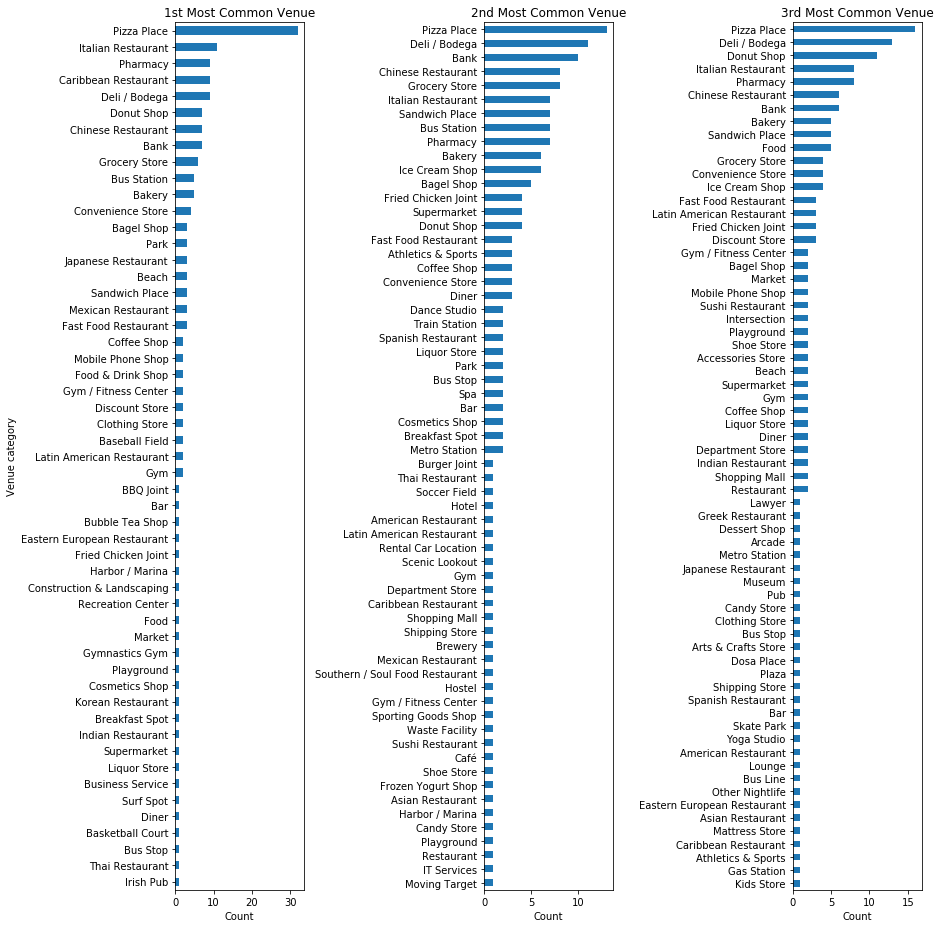

In [49]:
plt.figure(figsize=(13,13))

plt.subplot(1, 3, 1)
cluster2['1st Most Common Venue'].value_counts().plot(kind='barh')
plt.title('1st Most Common Venue')
plt.ylabel('Venue category')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 2)
cluster2['2nd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('2nd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
cluster2['3rd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('3rd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.tight_layout()


plt.show()

### Cluster 3

In [50]:
cluster3 = cities_merged.loc[cities_merged['Cluster Labels'] == 2, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]
cluster3

Neighborhood  Cluster Labels 1st Most Common Venue  \
304               Queensbridge               2                 Hotel   
0                 Rochechouart               2     French Restaurant   
1                Saint-Georges               2                 Hotel   
2             Chaussée-d'Antin               2                 Hotel   
3          Faubourg-Montmartre               2     French Restaurant   
6                Quinze-Vingts               2     French Restaurant   
7                      Bel-Air               2     Recreation Center   
8                       Halles               2     French Restaurant   
9                Place-Vendôme               2     French Restaurant   
10                Palais-Royal               2   Japanese Restaurant   
11   Saint-Germain-l'Auxerrois               2     French Restaurant   
12                     Arsenal               2     French Restaurant   
13                 Saint-Merri               2     French Restaurant   
14                  Notre-Dame               2     French Restaurant   
15               Saint-Gervais               2     French Restaurant   
16          Jardin-des-Plantes               2     French Restaurant   
17                Saint-Victor               2     French Restaurant   
18                Val-de-Grâce               2     French Restaurant   
19                    Sorbonne               2     French Restaurant   
21       Saint-Vincent-de-Paul               2     Indian Restaurant   
22           Porte-Saint-Denis               2                 Hotel   
23         Hôpital-Saint-Louis               2     French Restaurant   
24                    Roquette               2     French Restaurant   
25           Sainte-Marguerite               2     French Restaurant   
26              Saint-Ambroise               2                   Bar   
27             Folie-Méricourt               2     French Restaurant   
28                   Plaisance               2                 Hotel   
30                Montparnasse               2     French Restaurant   
31             Petit-Montrouge               2                 Hotel   
32                   Madeleine               2                 Hotel   
33                      Europe               2     French Restaurant   
34           Faubourg-du-Roule               2     French Restaurant   
35              Champs-Elysées               2     French Restaurant   
39                  Belleville               2                   Bar   
42                      Muette               2     French Restaurant   
43                    Chaillot               2                 Hotel   
44           Grandes-Carrières               2     French Restaurant   
45                 La Chapelle               2          Soccer Field   
46                Clignancourt               2     French Restaurant   
48                      Necker               2     French Restaurant   
49               Saint-Lambert               2     French Restaurant   
50                    Grenelle               2                 Hotel   
51                       Javel               2     French Restaurant   
52                 Batignolles               2     French Restaurant   
53          Plaine de Monceaux               2     French Restaurant   
54                   Epinettes               2   Japanese Restaurant   
55                      Ternes               2     French Restaurant   
56             Arts-et-Métiers               2     French Restaurant   
57                    Archives               2     French Restaurant   
58              Enfants-Rouges               2                 Hotel   
59                Sainte-Avoie               2     French Restaurant   
60                     Monnaie               2     French Restaurant   
61                       Odéon               2                 Hotel   
62      Saint-Germain-des-Prés               2     French Restaurant   
63       Notre-Dame-des-Champs               2     French 

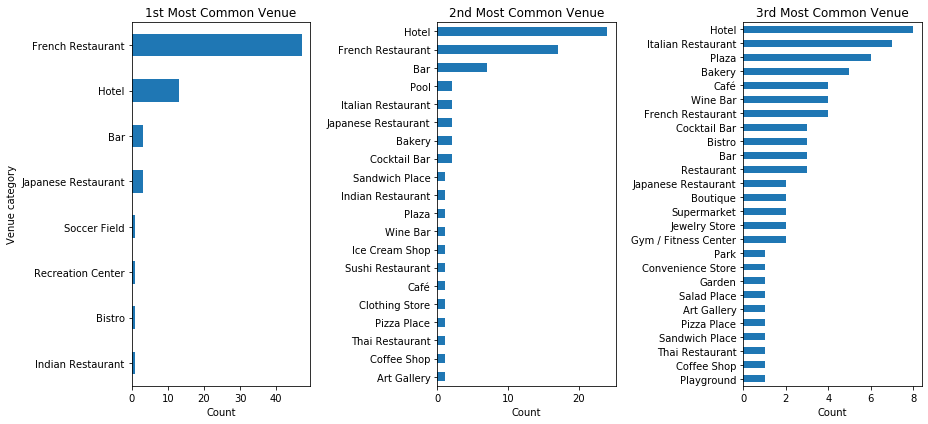

In [51]:
plt.figure(figsize=(13,6))

plt.subplot(1, 3, 1)
cluster3['1st Most Common Venue'].value_counts().plot(kind='barh')
plt.title('1st Most Common Venue')
plt.ylabel('Venue category')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 2)
cluster3['2nd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('2nd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
cluster3['3rd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('3rd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.tight_layout()

plt.show()

### Cluster 4

In [52]:
cluster4 = cities_merged.loc[cities_merged['Cluster Labels'] == 3, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]
cluster4

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
19     Roselawn               3                Garden           Zoo Exhibit   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
19               Factory        Duty-free Shop   EV Charging Station   

          6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
19  Eastern European Restaurant   Egyptian Restaurant     Electronics Store   

   9th Most Common Venue 10th Most Common Venue  
19   Empanada Restaurant     English Restaurant

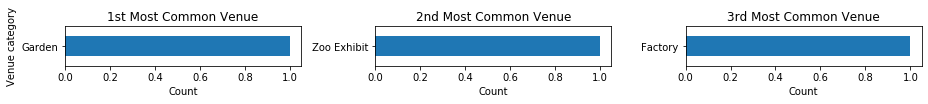

In [53]:
plt.figure(figsize=(13,1.5))

plt.subplot(1, 3, 1)
cluster4['1st Most Common Venue'].value_counts().plot(kind='barh')
plt.title('1st Most Common Venue')
plt.ylabel('Venue category')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 2)
cluster4['2nd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('2nd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
cluster4['3rd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('3rd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.tight_layout()

plt.show()

### Cluster 5

In [54]:
cluster5 = cities_merged.loc[cities_merged['Cluster Labels'] == 4, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]
cluster5

Neighborhood  Cluster Labels 1st Most Common Venue  \
29   Moore Park, Summerhill East               4                  Park   
192                   Somerville               4                  Park   
203                    Todt Hill               4                 Trail   
303                    Bayswater               4                  Park   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
29            Zoo Exhibit            Eye Doctor        Duty-free Shop   
192           Zoo Exhibit            Eye Doctor        Duty-free Shop   
203                  Park           Zoo Exhibit               Exhibit   
303            Playground           Zoo Exhibit               Exhibit   

    5th Most Common Venue        6th Most Common Venue  \
29    EV Charging Station  Eastern European Restaurant   
192   EV Charging Station  Eastern European Restaurant   
203        Duty-free Shop          EV Charging Station   
303        Duty-free Shop          EV Charging Station   

           7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
29           Egyptian Restaurant     Electronics Store   Empanada Restaurant   
192          Egyptian Restaurant     Electronics Store   Empanada Restaurant   
203  Eastern European Restaurant   Egyptian Restaurant     Electronics Store   
303  Eastern European Restaurant   Egyptian Restaurant     Electronics Store   

    10th Most Common Venue  
29      English Restaurant  
192     English Restaurant  
203    Empanada Restaurant  
303    Empanada Restaurant

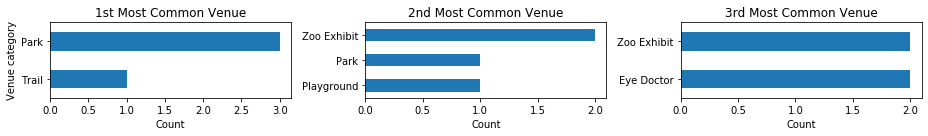

In [55]:
plt.figure(figsize=(13,2))

plt.subplot(1, 3, 1)
cluster5['1st Most Common Venue'].value_counts().plot(kind='barh')
plt.title('1st Most Common Venue')
plt.ylabel('Venue category')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 2)
cluster5['2nd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('2nd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
cluster5['3rd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('3rd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.tight_layout()

plt.show()

### Cluster 6

In [56]:
cluster6 = cities_merged.loc[cities_merged['Cluster Labels'] == 5, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]
cluster6

Neighborhood  Cluster Labels  \
0                            Regent Park, Harbourfront               5   
1          Queen's Park, Ontario Provincial Government               5   
2                             Garden District, Ryerson               5   
3                                       St. James Town               5   
4                                          The Beaches               5   
5                                          Berczy Park               5   
6                                   Central Bay Street               5   
7                                             Christie               5   
8                             Richmond, Adelaide, King               5   
9                         Dufferin, Dovercourt Village               5   
10   Harbourfront East, Union Station, Toronto Islands               5   
11                            Little Portugal, Trinity               5   
12                        The Danforth West, Riverdale               5   
13            Toronto Dominion Centre, Design Exchange               5   
14        Brockton, Parkdale Village, Exhibition Place               5   
16                      Commerce Court, Victoria Hotel               5   
17                                     Studio District               5   
18                                       Lawrence Park               5   
20                                    Davisville North               5   
21                            Forest Hill North & West               5   
22                       High Park, The Junction South               5   
23                                  North Toronto West               5   
24                 The Annex, North Midtown, Yorkville               5   
25                              Parkdale, Roncesvalles               5   
26                                          Davisville               5   
27                      University of Toronto, Harbord               5   
28                                  Runnymede, Swansea               5   
30           Kensington Market, Chinatown, Grange Park               5   
31   Summerhill West, Rathnelly, South Hill, Forest...               5   
32   CN Tower, King and Spadina, Railway Lands, Har...               5   
34                                      Stn A PO Boxes               5   
35                         St. James Town, Cabbagetown               5   
36              First Canadian Place, Underground city               5   
37                                Church and Wellesley               5   
38               Business reply mail Processing Centre               5   
3                                            Fieldston               5   
4                                            Riverdale               5   
9                                       Williamsbridge               5   
12                                         City Island               5   
22                                         Port Morris               5   
27                                        Clason Point               5   
35                                      Spuyten Duyvil               5   
46                                           Bay Ridge               5   
49                                          Greenpoint               5   
52                                      Sheepshead Bay               5   
58                                     Windsor Terrace               5   
59                                    Prospect Heights               5   
60                                         Brownsville               5   
61                                        Williamsburg               5   
62                                            Bushwick               5   
63                                  Bedford Stuyvesant               5   
64                                    Brooklyn Heights               5   
65                                         Cobble Hill               5   
66                                     Carroll

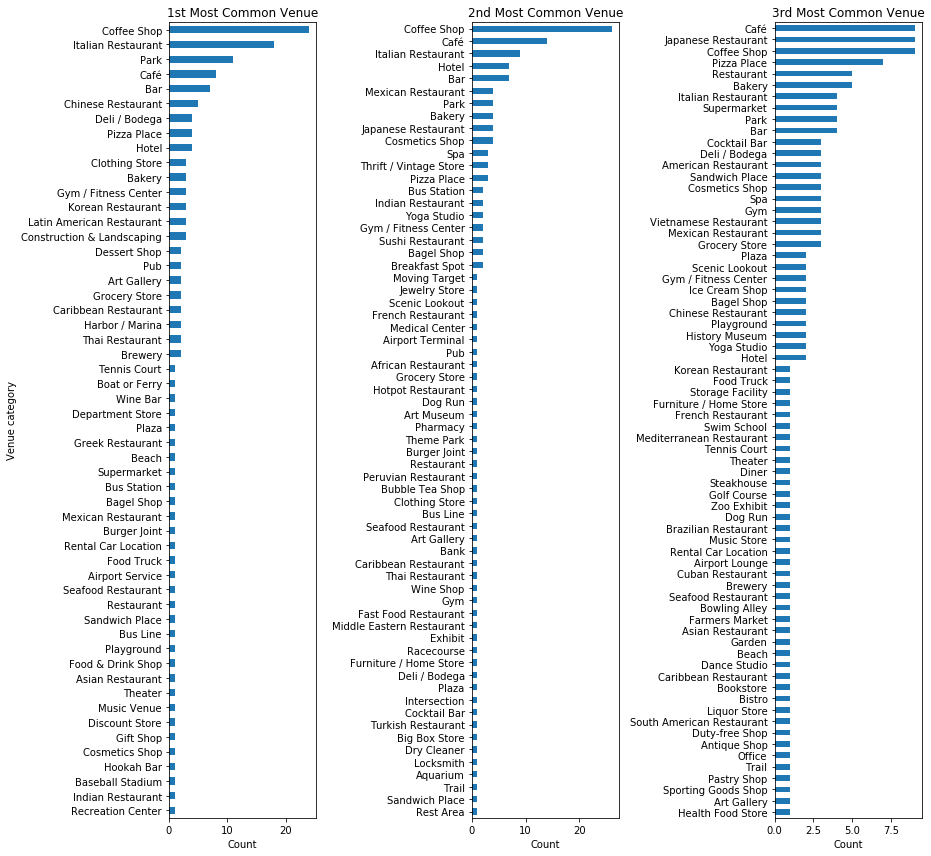

In [57]:
plt.figure(figsize=(13,12))

plt.subplot(1, 3, 1)
cluster6['1st Most Common Venue'].value_counts().plot(kind='barh')
plt.title('1st Most Common Venue')
plt.ylabel('Venue category')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 2)
cluster6['2nd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('2nd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
cluster6['3rd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('3rd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.tight_layout()

plt.show()

### Cluster 7

In [58]:
cluster7 = cities_merged.loc[cities_merged['Cluster Labels'] == 6, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]
cluster7

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
212      Oakwood               6                   Bar                Lawyer   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
212           Zoo Exhibit   Dumpling Restaurant   EV Charging Station   

           6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
212  Eastern European Restaurant   Egyptian Restaurant     Electronics Store   

    9th Most Common Venue 10th Most Common Venue  
212   Empanada Restaurant     English Restaurant

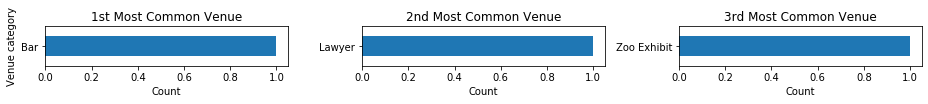

In [59]:
plt.figure(figsize=(13,1.5))

plt.subplot(1, 3, 1)
cluster7['1st Most Common Venue'].value_counts().plot(kind='barh')
plt.title('1st Most Common Venue')
plt.ylabel('Venue category')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 2)
cluster7['2nd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('2nd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
cluster7['3rd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('3rd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.tight_layout()

plt.show()

In [60]:
### Cluster 8

In [61]:
cluster8 = cities_merged.loc[cities_merged['Cluster Labels'] == 7, cities_merged.columns[[1] + list(range(5, cities_merged.shape[1]))]]
cluster8

Neighborhood  Cluster Labels 1st Most Common Venue  \
77    Manhattan Beach               7                  Café   
172      Breezy Point               7              Bus Stop   
179          Neponsit               7                 Beach   
193        Brookville               7         Deli / Bodega   
198      New Brighton               7              Bus Stop   
202       Grymes Hill               7               Dog Run   
204       South Beach               7                  Pier   
205     Port Richmond               7   Rental Car Location   
206  Mariner's Harbor               7    Italian Restaurant   
219       Silver Lake               7              Bus Stop   
224         Park Hill               7              Bus Stop   
226      Graniteville               7        Sandwich Place   
227         Arlington               7              Bus Stop   
241     Arden Heights               7              Bus Stop   
256     Randall Manor               7              Bus Stop   
258          Elm Park               7         Deli / Bodega   
285       Willowbrook               7              Bus Stop   
286      Sandy Ground               7              Bus Stop   
302           Hammels               7                 Beach   
305         Fox Hills               7              Bus Stop   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
77               Bus Stop                  Food        Ice Cream Shop   
172                 Trail                 Beach   Monument / Landmark   
179           Zoo Exhibit            Eye Doctor        Duty-free Shop   
193               Factory        Duty-free Shop   EV Charging Station   
198         Deli / Bodega                  Park            Playground   
202              Bus Stop           Zoo Exhibit            Eye Doctor   
204              Bus Stop    Athletics & Sports                 Beach   
205            Donut Shop            Playground              Bus Stop   
206         Deli / Bodega     Other Repair Shop              Bus Stop   
219          Burger Joint           Golf Course   American Restaurant   
224    Athletics & Sports                 Hotel  Gym / Fitness Center   
226         Boat or Ferry         Grocery Store              Bus Stop   
227         Deli / Bodega          Intersection           Coffee Shop   
241              Pharmacy           Pizza Place           Coffee Shop   
256            Bagel Shop           Pizza Place         Deli / Bodega   
258              Bus Stop           Pizza Place   American Restaurant   
285           Pizza Place         Deli / Bodega           Zoo Exhibit   
286                Market          Intersection           Zoo Exhibit   
302              Bus Stop  Fast Food Restaurant            Shoe Store   
305         Grocery Store        Sandwich Place           Zoo Exhibit   

           5th Most Common Venue        6th Most Common Venue  \
77                         Beach                   Playground   
172                  Zoo Exhibit  Eastern European Restaurant   
179          EV Charging Station  Eastern European Restaurant   
193  Eastern European Restaurant          Egyptian Restaurant   
198                Bowling Alley               Discount Store   
202          EV Charging Station  Eastern European Restaurant   
204                Deli / Bodega                      Exhibit   
205          Dumpling Restaurant               Duty-free Shop   
206                      Factory  Eastern European Restaurant   
219                      Exhibit                  Event Space   
224                  Coffee Shop                  Event Space   
226                  Zoo Exhibit        Entertainment Service   
227                Grocery Store          American Restaurant   
241          Dumpling Restaurant               Duty-free Shop   
256          EV Charging Station  Eastern European Restaurant   
258               Ice Cream Shop                   Toll Plaza   
285                   Eye Doctor          EV C

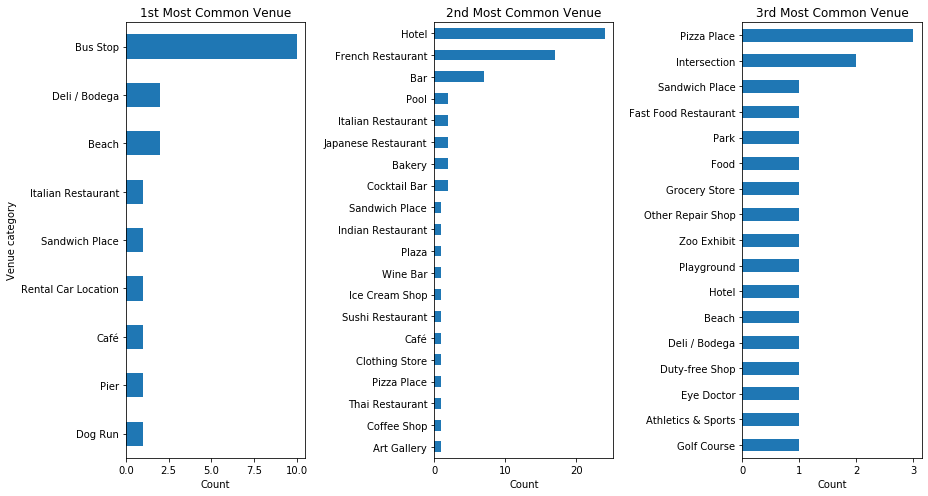

In [62]:
plt.figure(figsize=(13,7))

plt.subplot(1, 3, 1)
cluster8['1st Most Common Venue'].value_counts().plot(kind='barh')
plt.title('1st Most Common Venue')
plt.ylabel('Venue category')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 2)
cluster3['2nd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('2nd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
cluster8['3rd Most Common Venue'].value_counts().plot(kind='barh')
plt.title('3rd Most Common Venue')
plt.xlabel('Count')
plt.gca().invert_yaxis()

plt.tight_layout()

plt.show()